In [16]:
# 批量归一化的从零实现
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum): 
    # gamma beta 可学习的参数
    # moving_mean, moving_var 可以看做整个数据集上的均值和方差
    # eps 就是那个小噪声，避免除 0 的东西，一般是个固定数值
    # momentum 就是用来更新 moving_mean 和 moving_var 的，一般是个固定数值（0.9）
    # 通过 is_grad_enabled 来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 不要算梯度，就是如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # X.shape 要么是 2 -> 全连接层，要么是 4 -> 卷积层
        # 全连接层 (batch_size, feature)
        # 卷积层 (batch_size, channels, height, width)
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) **2).mean(dim=0)
        else:
            # 这里使用二维卷积的情况，计算二维特征上的均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) **2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        # （有点像动量更新）
        moving_mean = momentum + moving_mean + (1.0 - momentum) * mean
        moving_var = momentum + moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [17]:
# 创建一个正确的 BatchNorm 图层
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # ⾮模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)
        
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
            
        # 保存更新过的 moving_mean 和 moving_var
        Y, self.moving_mean, self.movingvar = batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

应用 `BatchNorm` 与 LeNet 模型

In [18]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
    nn.Sigmoid(), nn.Linear(84, 10)
)

loss 0.246, train acc 0.909, test acc 0.100
14229.8 examples/sec on cuda:0


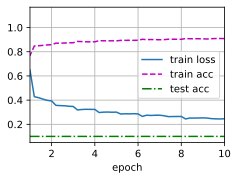

In [19]:
# 在 Fashion-MNIST 训练
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [20]:
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1, ))

(tensor([1.9418, 1.8420, 2.2969, 1.6313, 1.0261, 2.1582], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([ 0.4235,  1.0269,  0.1300,  0.0848, -1.0572, -2.1295], device='cuda:0',
        grad_fn=<ViewBackward>))

简明实现

In [25]:
net_simple = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
    nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84),
    nn.Sigmoid(), nn.Linear(84, 10)
)

loss 0.245, train acc 0.910, test acc 0.723
23570.7 examples/sec on cuda:0


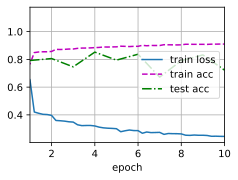

In [26]:
# 在 Fashion-MNIST 训练
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net_simple, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

为什么加入 BN 之后收敛时间会变短？
+ 可以认为加入 BN 之后地形图更加平坦，收敛会更加快
+ 加入 BN 之后梯度会增大，同时就可以使用更大的学习率 